## Predicting bitcoin with LSTM


In [ ]:
#import libraries

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()



In [3]:
df = pd.read_csv('data/btc.csv')
df.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [4]:
data =df['Close'].values

In [5]:
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1,1))

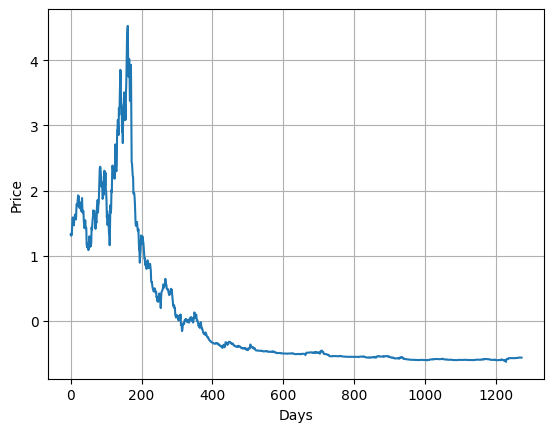

In [6]:
#plot 
plt.plot(data)
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()

In [7]:
def get_data(data, window_size):
    X = []
    y = []
    
    i = 0
    
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [8]:
X, y = get_data(data, window_size = 7)

In [9]:
#train and test sets

#train set
X_train  = np.array(X[:1000])
y_train = np.array(y[:1000])

#test set
X_test = np.array(X[1000:])
y_test = np.array(y[1000:])

In [10]:
X_train.shape

(1000, 7, 1)

In [11]:
#defining network parameters

batch_size = 7
window_size = 7 
hidden_layer = 256 
learning_rate = 0.001 

In [12]:
#defining placeholders

input = tf.compat.v1.placeholder(tf.float32, [batch_size, window_size, 1])
target = tf.compat.v1.placeholder(tf.float32, [batch_size, 1])

In [ ]:
#defining weights
#input gate
U_i = tf.compat.v1.Variable(tf.compat.v1.truncated_normal([1, hidden_layer], stddev=0.05))
W_i = tf.compat.v1.Variable(tf.compat.v1.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_i = tf.compat.v1.Variable(tf.zeros([hidden_layer]))

In [15]:
#forget gate


U_f = tf.compat.v1.Variable(tf.compat.v1.truncated_normal([1, hidden_layer], stddev=0.05))
W_f = tf.compat.v1.Variable(tf.compat.v1.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_f = tf.compat.v1.Variable(tf.zeros([hidden_layer]))


In [16]:
#output gate


U_o = tf.compat.v1.Variable(tf.compat.v1.truncated_normal([1, hidden_layer], stddev=0.05))
W_o = tf.compat.v1.Variable(tf.compat.v1.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_o = tf.compat.v1.Variable(tf.zeros([hidden_layer]))

In [17]:
#weights of candidate states

U_g = tf.compat.v1.Variable(tf.compat.v1.truncated_normal([1, hidden_layer], stddev=0.05))
W_g = tf.compat.v1.Variable(tf.compat.v1.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_g = tf.compat.v1.Variable(tf.zeros([hidden_layer]))


In [18]:
#output layer weight
V = tf.compat.v1.Variable(tf.compat.v1.truncated_normal([hidden_layer, 1], stddev=0.05))
b_v = tf.compat.v1.Variable(tf.zeros([1]))


In [19]:
#LSTM cell

def LSTM_cell(input, prev_hidden_state, prev_cell_state):


    it = tf.sigmoid(tf.matmul(input, U_i) + tf.matmul(prev_hidden_state, W_i) + b_i)
    ft = tf.sigmoid(tf.matmul(input, U_f) + tf.matmul(prev_hidden_state, W_f) + b_f)
    ot = tf.sigmoid(tf.matmul(input, U_o) + tf.matmul(prev_hidden_state, W_o) + b_o)
    gt = tf.tanh(tf.matmul(input, U_g) + tf.matmul(prev_hidden_state, W_g) + b_g)
    ct = (prev_cell_state * ft) + (it * gt)
    ht = ot * tf.tanh(ct)

    return ct, ht

In [20]:
#defining forward propagation

#initialize the list called y_hat for storing the predicted output
y_hat = []

#for each batch we compute the output and store it in the y_hat list
for i in range(batch_size): 
  
    #initialize hidden state and cell state for each batch
    hidden_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    cell_state = np.zeros([1, hidden_layer], dtype=np.float32)
    
    
    #compute the hidden state and cell state of the LSTM cell for each time step
    for t in range(window_size):
        cell_state, hidden_state = LSTM_cell(tf.reshape(input[i][t], (-1, 1)), hidden_state, cell_state)
        
    #compute y_hat and append it to y_hat list
    y_hat.append(tf.matmul(hidden_state, V) + b_v)


In [22]:
#Defining backpropagation
losses = []

for i in range(len(y_hat)):
    losses.append(tf.compat.v1.losses.mean_squared_error(tf.reshape(target[i], (-1, 1)), y_hat[i]))
    
loss = tf.reduce_mean(losses)


In [24]:
gradients = tf.gradients(loss, tf.compat.v1.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4.0)

In [27]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).apply_gradients(zip(gradients, tf.compat.v1.trainable_variables()))


In [29]:
#training the lstm model
session = tf.compat.v1.Session()
session.run(tf.compat.v1.global_variables_initializer())


In [30]:
epochs = 100

In [34]:
for i in range(epochs):
    train_predictions = []
    index = 0
    epoch_loss = []
    
    #Sample some batche of data and train the network
    while(index + batch_size) <= len(X_train):
        
        #sample batch of data
        X_batch = X_train[index:index+batch_size]
        y_batch = y_train[index:index+batch_size]
        
        #predict the prices and compute loss
        predicted, loss_val, _ = session.run([y_hat, loss, optimizer], feed_dict={input:X_batch, target:y_batch})
        
        #store the loss
        epoch_loss.append(loss_val)
        
        #store the predictions
        train_predictions.append(predicted)
        index += batch_size
        
        
    #print the loss on every 10 iterations
    if (i % 10)== 0:
        print('Epoch {}, Loss: {} '.format(i,np.mean(epoch_loss)))

Epoch 0, Loss: 0.19160188734531403 
Epoch 10, Loss: 0.04048078879714012 
Epoch 20, Loss: 0.02398882806301117 
Epoch 30, Loss: 0.019006701186299324 
Epoch 40, Loss: 0.010632812976837158 
Epoch 50, Loss: 0.014990714378654957 
Epoch 60, Loss: 0.00905490480363369 
Epoch 70, Loss: 0.00885548535734415 
Epoch 80, Loss: 0.008137242868542671 
Epoch 90, Loss: 0.007176835555583239 


In [35]:
#making predictions using the LSTM model

In [36]:

predicted_output = []
i = 0
while i+batch_size <= len(X_test): 
  
    output = session.run([y_hat],feed_dict={input:X_test[i:i+batch_size]})
    i += batch_size
    predicted_output.append(output)

In [37]:
predicted_output[0]

[[array([[-0.6039788]], dtype=float32),
  array([[-0.60177356]], dtype=float32),
  array([[-0.60092986]], dtype=float32),
  array([[-0.5995633]], dtype=float32),
  array([[-0.59913456]], dtype=float32),
  array([[-0.600502]], dtype=float32),
  array([[-0.5972058]], dtype=float32)]]

In [38]:

predicted_values_test = []
for i in range(len(predicted_output)):
  for j in range(len(predicted_output[i][0])):
    predicted_values_test.append(predicted_output[i][0][j])

In [39]:
predicted_values_test[0]

array([[-0.6039788]], dtype=float32)

In [40]:
predictions = []
for i in range(1280):
      if i >= 1000:
        predictions.append(predicted_values_test[i-1019])
      else:
        predictions.append(None)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1280,) + inhomogeneous part.

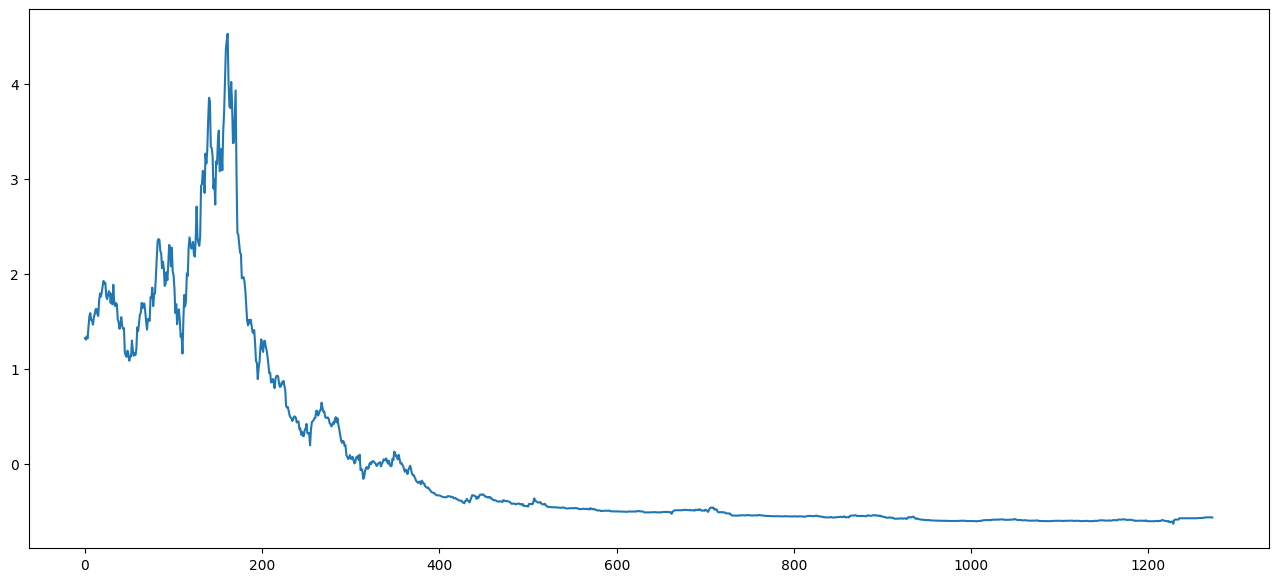

In [44]:

plt.figure(figsize=(16, 7))
plt.plot(np.array(data).flatten(), label='Actual')
plt.plot(np.array(predictions).flatten(), label='Predicted')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid()
plt.show()